# The hippocampus as a predictive map
Kimberly L Stachenfeld, Matthew M Botvinick & Samuel J Gershman 

https://www.nature.com/articles/nn.4650

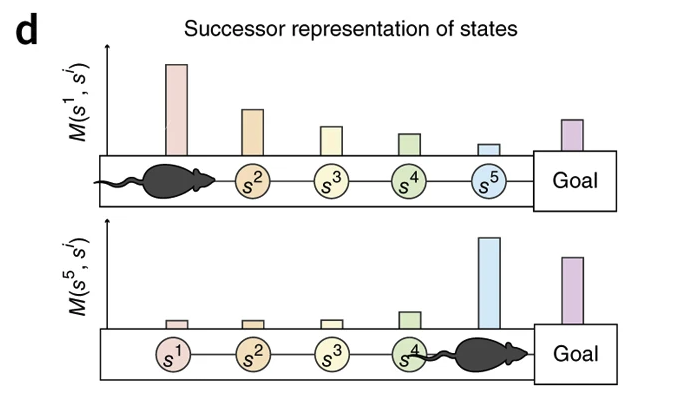

In this notbook we provide easy example on how to run the Succesor Representation (SR) model presented in the paper 'The hippocampus as a predictive map  model'. 
The model is run in multiple different types of environements both generic and build from experimental data.

In [1]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
from neuralplayground.arenas import Simple2D, MergingRoom, Sargolini2006, Hafting2008, BasicSargolini2006,Wernle2018
from neuralplayground.utils import create_circular_wall
from neuralplayground.agents import  Stachenfeld2018


## Initialise the arena

We first create a random 2D arena for the agent to interact with. For more information on how to create arena refer to the arena jupyter notebook.

In [2]:
room_width = [-6,6]
room_depth = [-6,6]
env_name = "env_example"
time_step_size = 0.2
agent_step_size = 0.5
# Init environment
env = Simple2D(environment_name=env_name,
               arena_x_limits = room_width,
               arena_y_limits = room_depth,
               time_step_size = time_step_size,
               agent_step_size = agent_step_size)


## Initialise the SR agent

In [3]:
discount = .9
threshold = 1e-6
lr_td = 0.2
t_episode = 100#1000
n_episode = 100#1000
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density,twoD=True)

If we assume we know the transition matrix  $T_t(s,s′)$ is the probability of transitioning from s to s′ in exactly t step, one can compute the successor representation using successive additive update

$$ M= \sum_{t=0}^{\infty} \gamma^tT^t $$

We use this as sanity check for our results bellow. 

In [4]:
sr_sum= agent.successor_rep_sum()

We plot the transition matrix and the eigenvectors of the Successor Matrix $M$. Choose an array of four eigenvectors you would like to plot. 

array([[0.        , 0.5       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 0.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.33333333, 0.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.        ]])

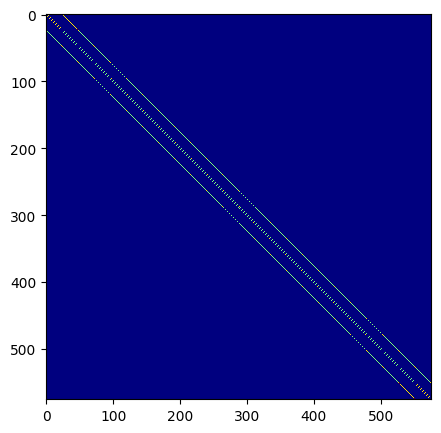

In [5]:
agent.create_transmat(state_density = 0, name_env = "2D_env", plotting_variable=True)

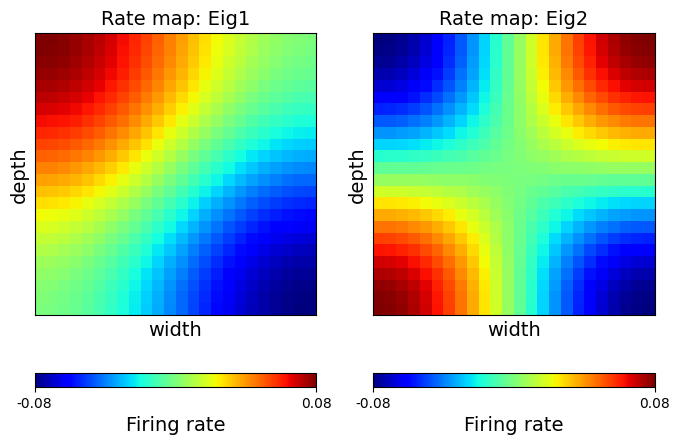

In [6]:
agent.plot_rate_map(sr_matrix = sr_sum, eigen_vectors=[1,2],save_path=None)


One can compute the successor representation matrix using geometric sums for $\gamma<1$
$$ M= \sum_{t=0}^{\infty} \gamma^tT^t =(I-\gamma T)^{-1}$$

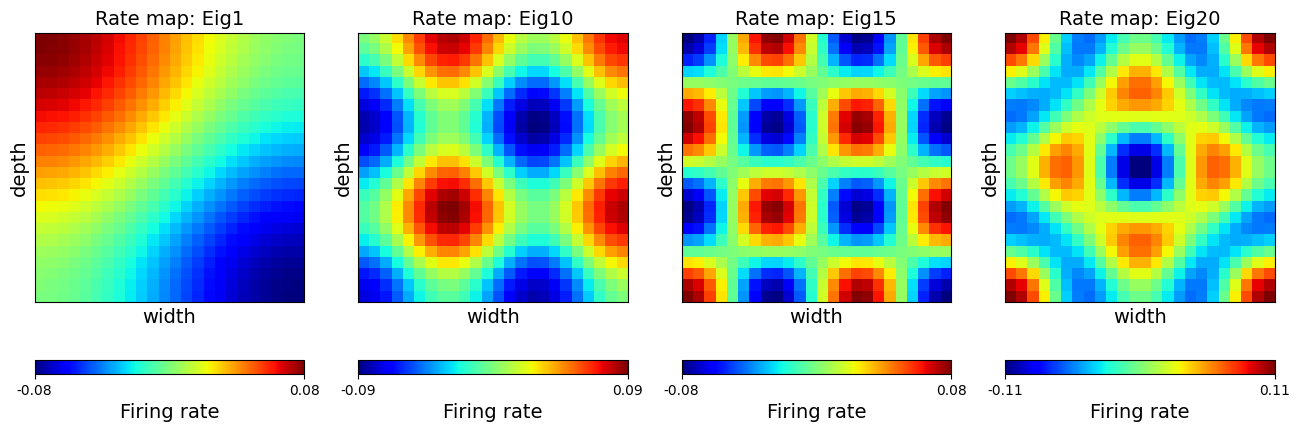

In [7]:
sr = agent.successor_rep_solution()  
agent.plot_rate_map(sr_matrix=sr, eigen_vectors=[1,10,15,20],save_path=None)

Compute the successor representation matrix using TD learning

$$ M_{t+1}(s_t,s')= M_{t}(s_t,s')+\eta[I(s_t=s')+\gamma M_t(s_{t+1},s')-M_t(s_t,s')] $$

In [8]:
help(agent.update_successor_rep_td_full)

Help on method update_successor_rep_td_full in module neuralplayground.agents.stachenfeld_2018:

update_successor_rep_td_full(n_episode: int = 100, t_episode: int = 100) method of neuralplayground.agents.stachenfeld_2018.Stachenfeld2018 instance
    Compute the successor representation matrix using TD learning
    
    Returns:
    ----------
        srmat_full: (n_state, n_state)
            successor representation matrix



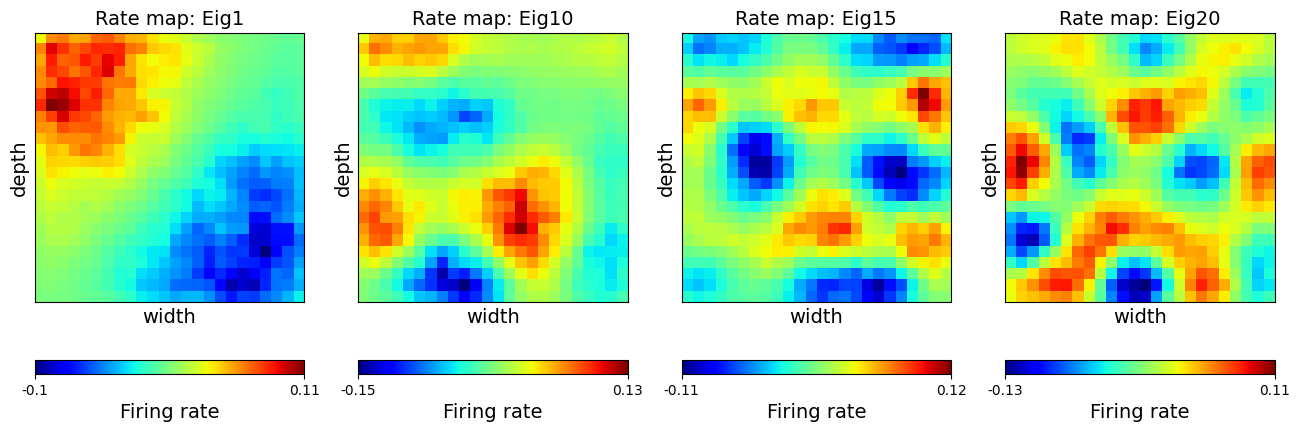

In [10]:
# Choose your function depending on the type of env '2D_env' or '1D_env' 
# Only run if twoDvalue=True
sr_td = agent.update_successor_rep_td_full(1000,1000)  
agent.plot_rate_map(sr_matrix=sr_td, eigen_vectors=[1,10,15,20], save_path=None)

## Agent and Arena Interaction

The agent receives observations from the environment (reward, visual cues, etc.) and uses these to take an action with the function ``` act```  which in turn will ``` update```  both its state and the state of the environment, generating new observations ```env.step``` . 

We note that the SR model is a discrete model as opposed to the arena which is continous. The discretization is done within the agent concidering that the state representation is build by the agent.

In [18]:
n_episode * t_episode

10000

  0%|          | 0/100 [00:00<?, ?it/s]

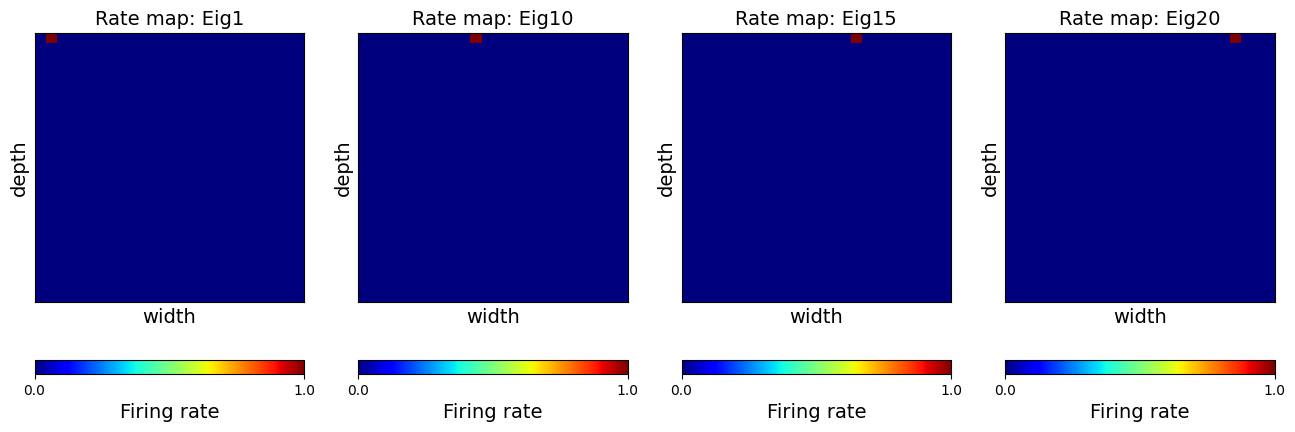

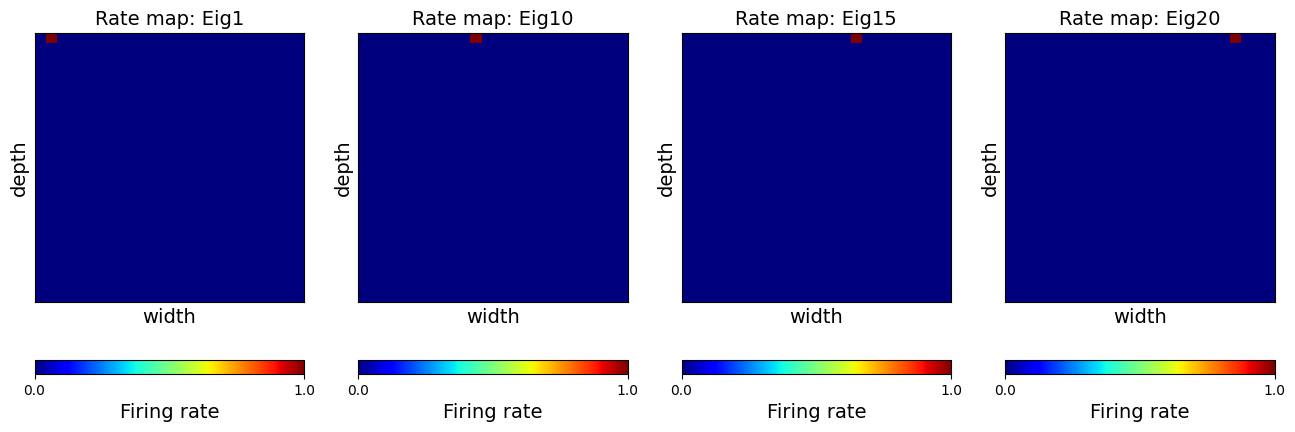

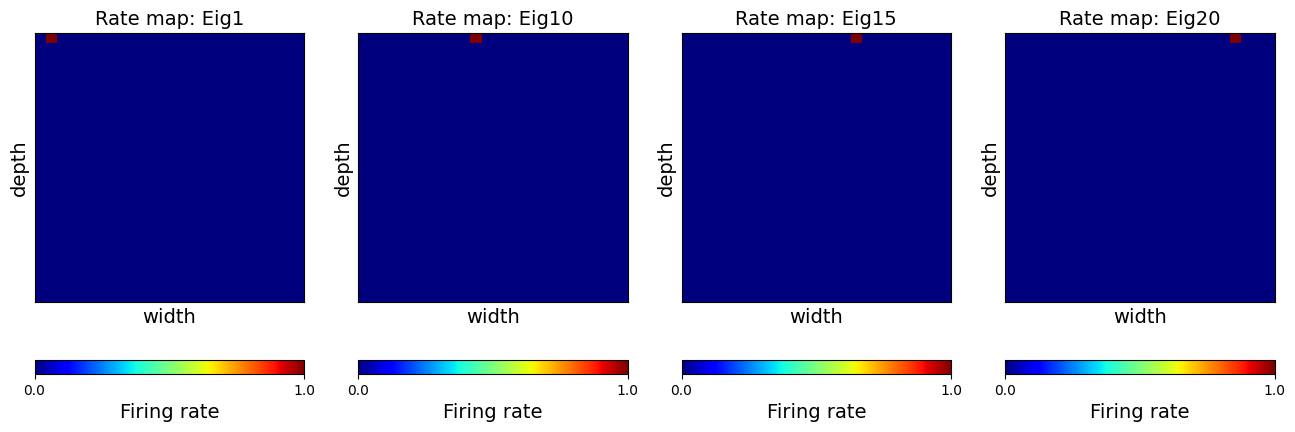

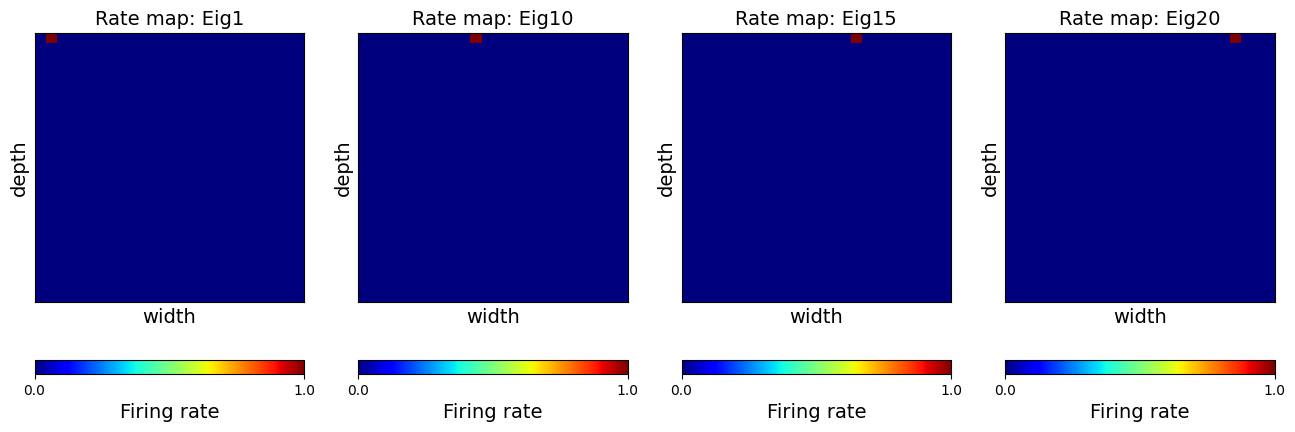

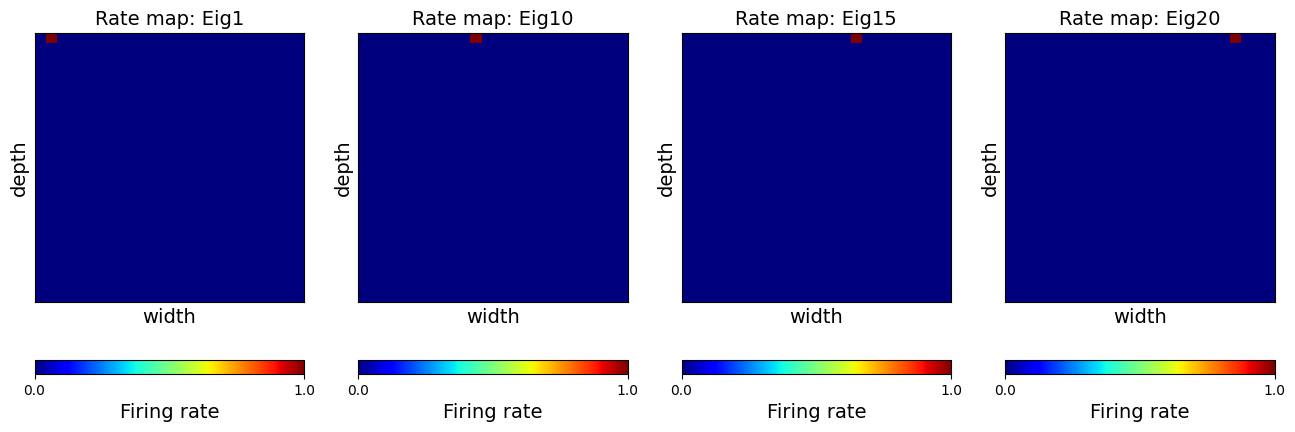

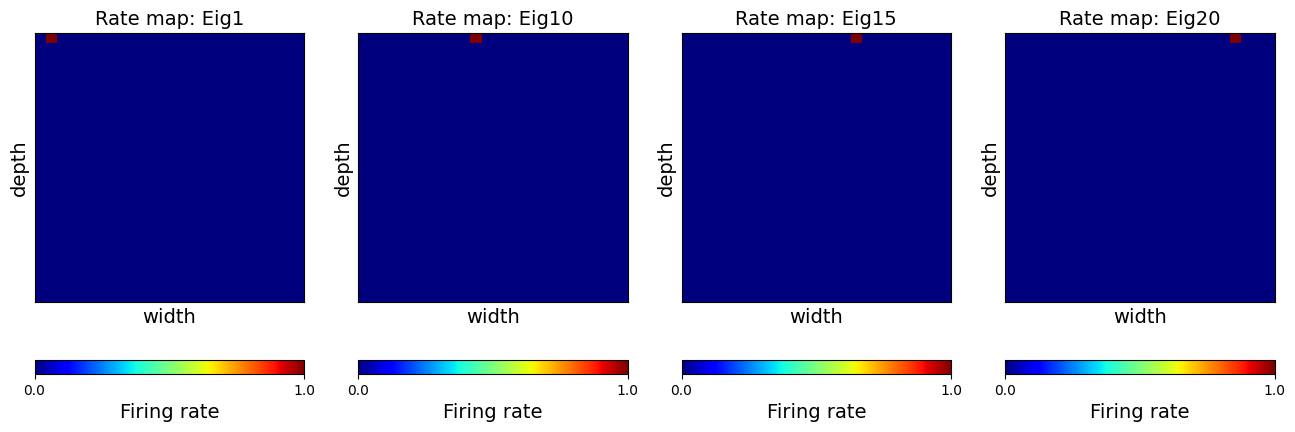

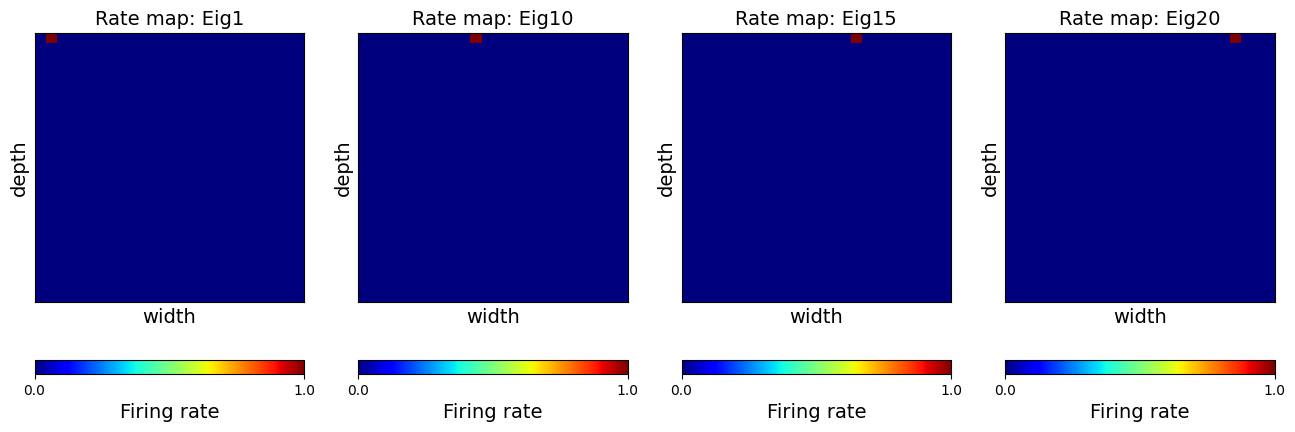

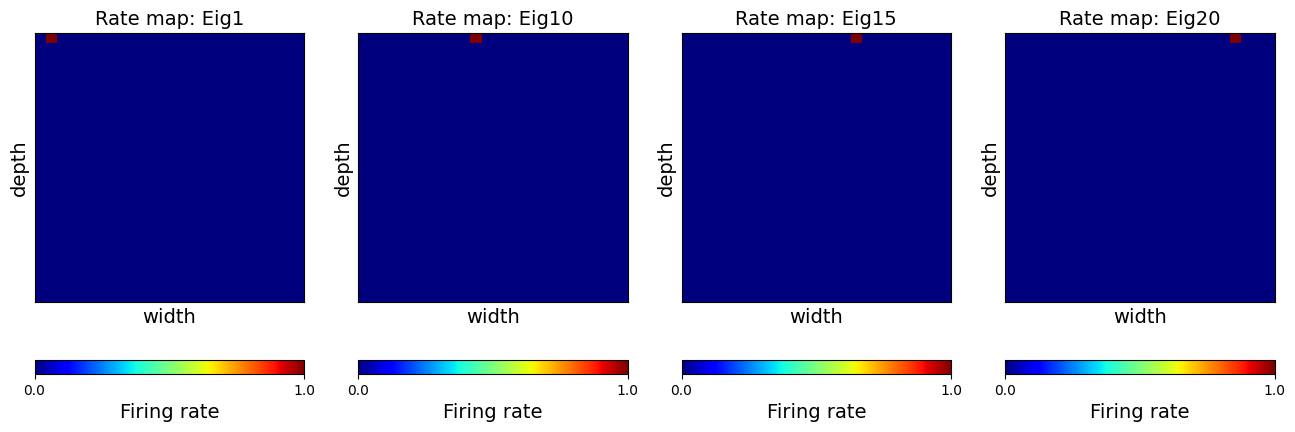

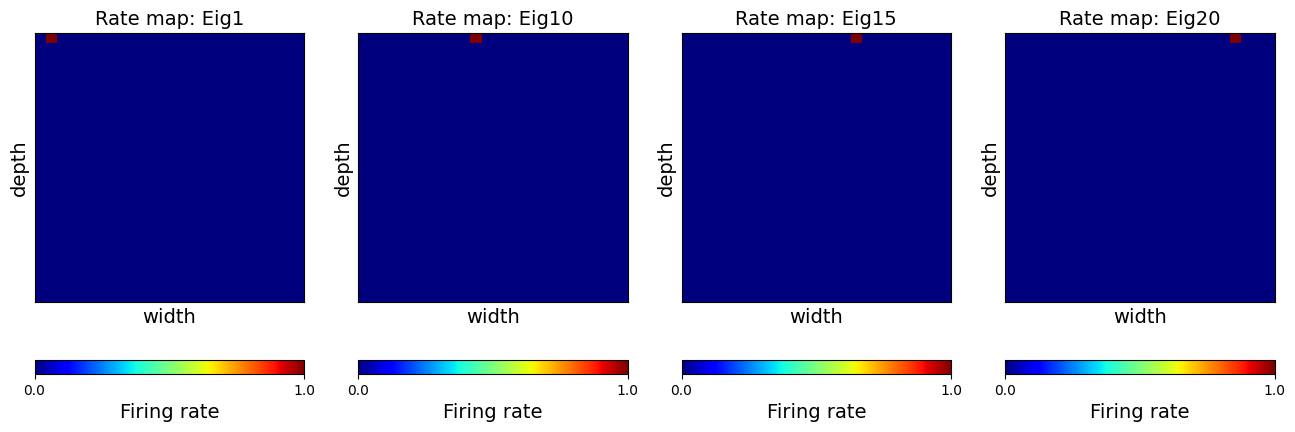

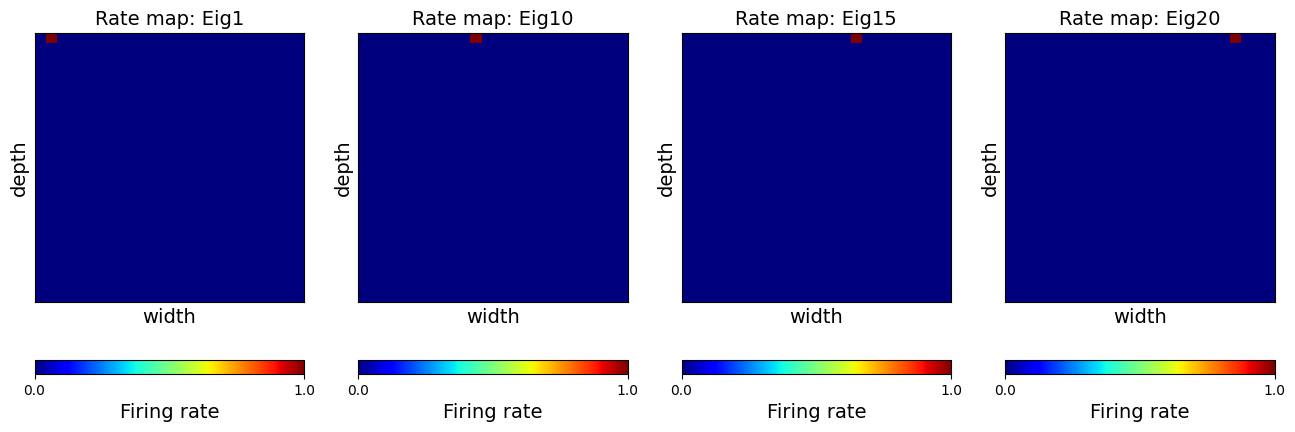

In [19]:
plot_every = 1000
total_iters = 0
obs, state = env.reset()
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        agent.update()
        obs, state, reward = env.step(action)
        obs = obs[:2]
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_rate_map(sr_matrix=agent.srmat, eigen_vectors=[1,10,15,20],save_path='./sr.png')


Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

array([<Axes: title={'center': 'Transition matrix'}, xlabel='states', ylabel='states'>,
       <Axes: title={'center': 'Transition calculated from SR matrix'}, xlabel='states', ylabel='states'>],
      dtype=object)

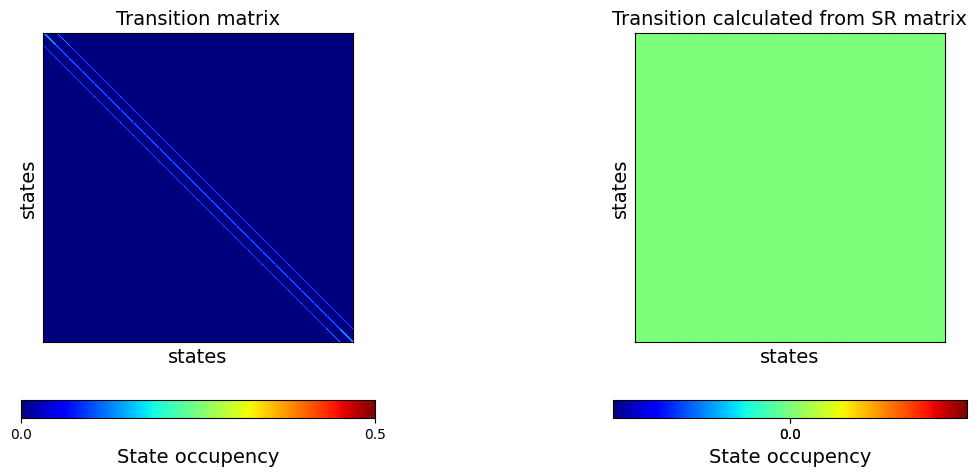

In [11]:
agent.plot_transition()

## Merging room

In [ ]:
agent_step_size = 1
time_step_size = 0.2
merging_time = 270*2.0  # Time in minutes to remove 
switch_time = 270.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 270.0
n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size

room_width = [-10,10]
room_depth = [-10,10]
env_name = "merging_room"

# Init environment
env = MergingRoom(arena_x_limits = room_width,
                  arena_y_limits = room_depth,
                  time_step_size = time_step_size,
                  agent_step_size = agent_step_size,
                  merge_time = merging_time,
                  switch_time = switch_time)


discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode =  1
n_episode =n_steps
state_density = (1 / agent_step_size)
twoDvalue = True

agent_Stachenfeld2018 = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=True)

obs, state = env.reset()     
plot_every = 100*100
total_iters = 0
for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent_Stachenfeld2018.act(obs[:2])
    # Run environment for given action
    agent_Stachenfeld2018.update()
    obs, state, reward = env.step(action)
  
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat, eigen_vectors=[1,10,15,20],save_path='./sr.png')

        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat,eigen_vectors=[1,2,3,4], save_path='./"pre_merge_merging_room.png')
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

In [ ]:
obs, state = env.reset()     
plot_every = 100*100
total_iters = 0
for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent_Stachenfeld2018.act(obs[:2])
    # Run environment for given action
    agent_Stachenfeld2018.update()
    obs, state, reward = env.step(action)
  
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat, eigen_vectors=[1,10,15,20],save_path='./sr.png')

        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        agent_Stachenfeld2018.plot_rate_map(sr_matrix=agent_Stachenfeld2018.srmat,eigen_vectors=[1,2,3,4], save_path='./"pre_merge_merging_room.png')
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Wernle.png')
plt.savefig("post_merge.pdf", bbox_inches="tight")

Plotting

In [ ]:
# agent.save_agent("post_merge.agent")
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)

agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path=None)
plt.savefig("post_merge.pdf", bbox_inches="tight")

In [ ]:
## Circular Arena

In [ ]:
class CircularArena(Simple2D):
    
    def _create_custom_walls(self):
        self.custom_walls = create_circular_wall(center=np.array([0, 0]), radius=50)  # One inner circle
        self.custom_walls += create_circular_wall(center=np.array([0, 0]), radius=75)  # One outer circle
        

In [ ]:
time_step_size = 1 #seg
agent_step_size = 1
arena_x_limits = np.array((-100, 100))
arena_y_limits = np.array((-100, 100))

# Init environment
env = CircularArena(time_step_size = time_step_size,
                    agent_step_size = agent_step_size,
                    arena_x_limits=arena_x_limits,
                    arena_y_limits=arena_y_limits)

In [ ]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 10
n_episode = 10
state_density = int(1 / agent_step_size)
agent =  Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density,twoD=True)

We do not expect that have good grid cells here as the state covers the all arena. One can consider building specific state space strucutre that is not 2D.

In [ ]:
plot_every = 1000
total_iters = 0
obs, state = env.reset(custom_state=[-70,0])
for i in tqdm(range(n_episode)):
    for j in range(t_episode):
        action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
        agent.update()
        obs, state, reward = env.step(action)
        obs = obs[:2]
        total_iters += 1
        if total_iters % plot_every == 0:
            agent.plot_rate_map(sr_matrix=agent.srmat, eigen=[1,10,15,20],save_path=None)

In [ ]:
ax = env.plot_trajectory()

ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
plt.savefig("circle.pdf", bbox_inches="tight")
plt.show()

## Experimental arenas

### Sargolini et al, 2006

We start with the data set from *Conjunctive Representation of Position, Direction, and Velocity in Entorhinal Cortex*, Sargolini et al 2006 (https://www.science.org/doi/10.1126/science.1125572)

Here we use the real behaviour data of the experiment.
Default is False and runs a random agent.

In [ ]:
env = Sargolini2006(time_step_size=0.1,
                         agent_step_size=None, use_behavioral_data = True, recording_index=2)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True
print(env.room_width)
print(env.room_depth)
agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep_td_full(n_episode=100, t_episode=100) # One can compute the successor representation using successive additive update
agent.plot_rate_map(agent.srmat_full_td, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr, eigen_vectors=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_rate_map(agent.srmat_sum, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr_sum, eigen_vectors=[1,10,15,20],save_path=None)


srmat_ground=agent.successor_rep_solution()
agent.plot_rate_map(agent.srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(srmat_ground, eigen_vectors=10,save_path ='./grids_sr_2')

Agent and Arena Interaction

In [ ]:
plot_every = 1000000
total_iters = 0
obs, state = env.reset()
for i in tqdm(range(1000000)):
# Observe to choose an action
    action = agent.act(obs[:2])  # the action is link to density of state to make sure we always land in a new
    agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Sargo.png')
        

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
agent.successor_rep_solution()
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition()

In [ ]:
ax = env.plot_trajectory()
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
plt.savefig("sargolini.pdf", bbox_inches="tight")
plt.show()

### Hafting et al, 2008

Let's look at *Hippocampus-independent phase precession in entorhinal grid cells* by Hafting et al 2008 (https://www.nature.com/articles/nature06957)

In [ ]:
env = Hafting2008(time_step_size=0.1,
                  agent_step_size=None,
                  use_behavioral_data=False)
    

Initialise the agent in this new environement

In [ ]:
agent_step_size = 10
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode = 1000
n_episode = 100
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
sr = agent.update_successor_rep_td_full(n_episode=100, t_episode=100) # One can compute the successor representation using successive additive update
agent.plot_rate_map(agent.srmat_full_td, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr, eigen_vectors=[1,10,15,20],save_path=None)

sr_sum = agent.successor_rep_sum() # One can compute the successor representation matrix using geometric sums for $\gamma<1$
agent.plot_rate_map(agent.srmat_sum, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(sr_sum, eigen_vectors=[1,10,15,20],save_path=None)


srmat_ground=agent.successor_rep_solution()
agent.plot_rate_map(agent.srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)
agent.plot_rate_map(srmat_ground, eigen_vectors=[1,10,15,20],save_path=None)

Agent and Arena Interaction

In [ ]:
plot_every = 100000
total_iters = 0
obs, state = env.reset()
obs = obs[:2]
for i in tqdm(range(100000)):
# Observe to choose an action
    action = agent.act(obs)  # the action is link to density of state to make sure we always land in a new
    K  = agent.update()
    obs, state, reward = env.step(action)
    obs= obs[:2]
    total_iters += 1
    if total_iters % plot_every == 0:
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Hating.png')

In [ ]:
print(env.room_depth)

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition()

In [ ]:
ax = env.plot_trajectory(plot_every=100)
plt.show()

### Wernle et al, 2018

- *Integration of grid maps in merged environments*, Wernle et al. 2018 (https://www.nature.com/articles/s41593-017-0036-6)

In [ ]:
import sys
sys.path.append("../")
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from tqdm import tqdm
from neuralplayground.arenas import Simple2D, MergingRoom, Sargolini2006, Hafting2008, BasicSargolini2006,Wernle2018
from neuralplayground.utils import create_circular_wall
from neuralplayground.agents import  Stachenfeld2018

In [ ]:
agent_step_size=10
time_step_size = 0.5
merging_time = 170*2.0  # Time in minutes to remove 
switch_time = 170.0 # Time in minutes to move the mouse to the other side of the arena
additional_time = 1470.0
n_steps = ((merging_time + switch_time + additional_time)*60) / time_step_size

env = Wernle2018(merge_time=merging_time,
                 switch_time=switch_time,
                 time_step_size=time_step_size,
                 agent_step_size=agent_step_size)


Initialise the agent in this new environement

In [ ]:
discount = .9
threshold = 1e-6
lr_td = 1e-2
t_episode =  1
n_episode =n_steps
state_density = (1 / agent_step_size)
twoDvalue = True

agent = Stachenfeld2018(discount=discount, t_episode=t_episode, n_episode=n_episode, threshold=threshold, lr_td=lr_td,
               room_width=env.room_width, room_depth=env.room_depth, state_density=state_density, twoD=twoDvalue)



In [ ]:
env.room_width

Agent and Arena interaction

In [ ]:
obs, state = env.reset()       
for j in tqdm(range(round(n_steps))):
    # Observe to choose an action
    action = agent.act(obs[:2])
    # Run environment for given action
    obs, state, reward = env.step(action)
    K  = agent.update()
    # We plot the trajectory of the agent just right before switching and before merging
    # then we keep running the loop
    if j == int((switch_time*60)/time_step_size)-1:
        # plot trajectory
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        # If you like, you can save the current state of the agent using the save_agent method to load the agent later
        # agent.save_agent("pre_switch.agent")
        # plot rates
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_pre_switch_time.png')
        plt.savefig("pre_switch.pdf", bbox_inches="tight")
    if j == int((merging_time*60)/time_step_size)-1:
        # Same thing, plotting just before the merging of the rooms
        ax = env.plot_trajectory(plot_every=100)
        ax.set_xlabel("width", fontsize=16)
        ax.set_ylabel("depth", fontsize=16)
        agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_pre_merge_time.png')
        plt.savefig("pre_merge.pdf", bbox_inches="tight")
        # agent.save_agent("pre_merge.agent")

Plotting the ground truth transition matrix and the transition matrix resulting from the interaction with the environment.

In [ ]:
# Here we take the section of interaction history for the period after the merge
merged_history = env.history[int((merging_time*60)/time_step_size):]
# Note that the wall is already removed from the arena structure
ax = env.plot_trajectory(history_data=merged_history, plot_every=100)
ax.set_xlabel("width", fontsize=16)
ax.set_ylabel("depth", fontsize=16)
agent.plot_rate_map(sr_matrix=agent.srmat,eigen_vectors=[1,10,15,20], save_path='./sr_Wernle.png')
plt.savefig("post_merge.pdf", bbox_inches="tight")

In [ ]:
agent.plot_transition()

In [ ]:
agent.successor_rep_solution()
T = agent.get_T_from_M(agent.srmat_ground)
agent.plot_transition(T=T)